# Taxi Rides Time Forecasting

The project goal is to create a predictive model to forecast the number of taxi rides that will happen in Manhattan (New York City):
- in the next hour
- for each taxi zone (e.g. Zone 113 "Lower Manhattan)

The data was retrieved from [here](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

### Load Workspace

In [1]:
import re
import datetime as dt
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from tqdm import notebook
from itertools import product
from typing import Union

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import VotingRegressor
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Load the Dataset

- The data dictionary for the Yellow taxi trip records is [here](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).
- The data dictionary for the Green taxi trip records is [here](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf).
- The data dictionary for the for-hire vehicle trip records is [here](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_fhv.pdf).
- The data dictionary for taxi zones is [here](https://d37ci6vzurychx.cloudfront.net/misc/taxi+_zone_lookup.csv).

In [2]:
yellow = pd.read_parquet('yellow_tripdata_2023-01.parquet')
green = pd.read_parquet('green_tripdata_2023-01.parquet')
for_hire = pd.read_parquet('fhv_tripdata_2023-01.parquet')
taxi_zones = pd.read_csv('taxi+_zone_lookup.csv')

In [3]:
yellow.info(), green.info(), for_hire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

(None, None, None)

### Data Transformation

We'll transform the raw data into (features, targets) and train-test split in 4 sub-steps:
- Validate the raw data
- Aggregate raw data into time-series
- Transform time-series into (features, target)
- Train-test split


**Determine Target Variable**

We need to group trips by pick up location ID and sum up all trips from the location. The sum value will be our target variable.

In [4]:
def aggregate_time_series(df, aggregation_column, time_series_column):
    df = df.drop(index=df.loc[df[aggregation_column].isnull()].index)
    df = df.drop(index=df.loc[df[aggregation_column].isin([264, 265])].index)
    
    df = df.loc[df[time_series_column].dt.year == 2023]
    df = df.groupby(aggregation_column).resample('H', on=time_series_column).size().reset_index()
    df.columns = ['location_id', 'datetime', 'total_trips']
    df = df.set_index('datetime')
    
    return df

yellow = aggregate_time_series(yellow, 'PULocationID', 'tpep_pickup_datetime')
green = aggregate_time_series(green, 'PULocationID', 'lpep_pickup_datetime')
for_hire = aggregate_time_series(for_hire, 'PUlocationID', 'pickup_datetime')


In [5]:
yellow.head()

,location_id,total_trips
datetime,,
2023-01-01 05:00:00,1,1
2023-01-01 06:00:00,1,0
2023-01-01 07:00:00,1,0
2023-01-01 08:00:00,1,1
2023-01-01 09:00:00,1,0


**Handling Missing Data**

In [6]:
for df, df_name in zip([yellow, green, for_hire], ['yellow', 'green', 'for_hire']):
    print(f'NUMBER OF MISSING VALUES IN {df_name} DATASET: \n')
    display(df.isnull().sum().sort_values(ascending=False))
    
    n_rows, n_cols = df.shape[0], yellow.shape[1]
    n_cells = (n_rows * n_cols)
    n_missing = yellow.isnull().sum().sum()
    
    print(f"Missing value percentage in dataset {round((n_missing / n_cells) * 100, 3)}%")

    print("---" *20)

NUMBER OF MISSING VALUES IN yellow DATASET: 


location_id    0
total_trips    0
dtype: int64

Missing value percentage in dataset 0.0%
------------------------------------------------------------
NUMBER OF MISSING VALUES IN green DATASET: 


location_id    0
total_trips    0
dtype: int64

Missing value percentage in dataset 0.0%
------------------------------------------------------------
NUMBER OF MISSING VALUES IN for_hire DATASET: 


location_id    0
total_trips    0
dtype: int64

Missing value percentage in dataset 0.0%
------------------------------------------------------------


### Visualize Data

In [7]:
deep_colors = [
    '#2e921b', '#7f1b92', '#4C72B0', '#55A868',
    '#C44E52', '#8172B2', '#CCB974', '#64B5CD'
]

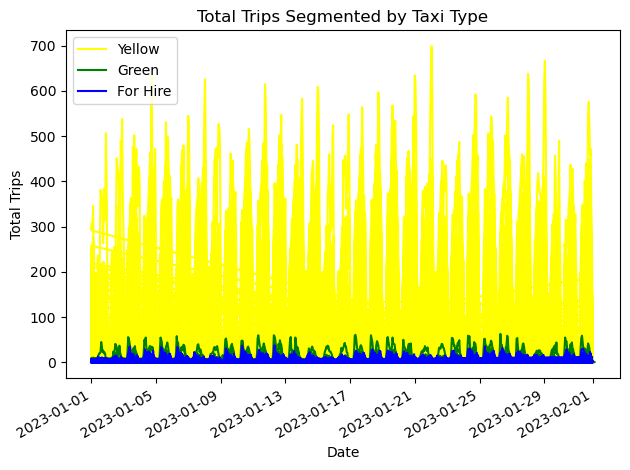

In [8]:
fig, ax = plt.subplots()

ax.plot(yellow.total_trips, color='yellow', label='Yellow')
ax.plot(green.total_trips, color='green', label='Green')
ax.plot(for_hire.total_trips, color='blue', label='For Hire')
ax.set_xlabel('Date')
ax.set_ylabel('Total Trips')
ax.set_title('Total Trips Segmented by Taxi Type')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Select top 5 Highest Locations for Different Taxis

In [9]:
yellow_top_5_locs = yellow.groupby('location_id').sum().sort_values(by='total_trips', ascending=False).index[:5]
print(yellow_top_5_locs)

green_top_5_locs = green.groupby('location_id').sum().sort_values(by='total_trips', ascending=False).index[:5]
print('\n', green_top_5_locs)

fh_top_5_locs = for_hire.groupby('location_id').sum().sort_values(by='total_trips', ascending=False).index[:6]
print('\n', fh_top_5_locs)

Index([132, 237, 236, 161, 186], dtype='int64', name='location_id')

 Index([74, 75, 41, 166, 95], dtype='int64', name='location_id')

 Index([206.0, 92.0, 221.0, 7.0, 129.0, 179.0], dtype='float64', name='location_id')


In [10]:
yellow_132 = yellow.loc[yellow.location_id == yellow_top_5_locs[0], 'total_trips'].asfreq('H')

green_74 = yellow.loc[yellow.location_id == green_top_5_locs[0], 'total_trips'].asfreq('H')

fh_206 = yellow.loc[yellow.location_id == fh_top_5_locs[0], 'total_trips'].asfreq('H')

### Yellow 132 - Forecasting

**Time Series Decomposition**

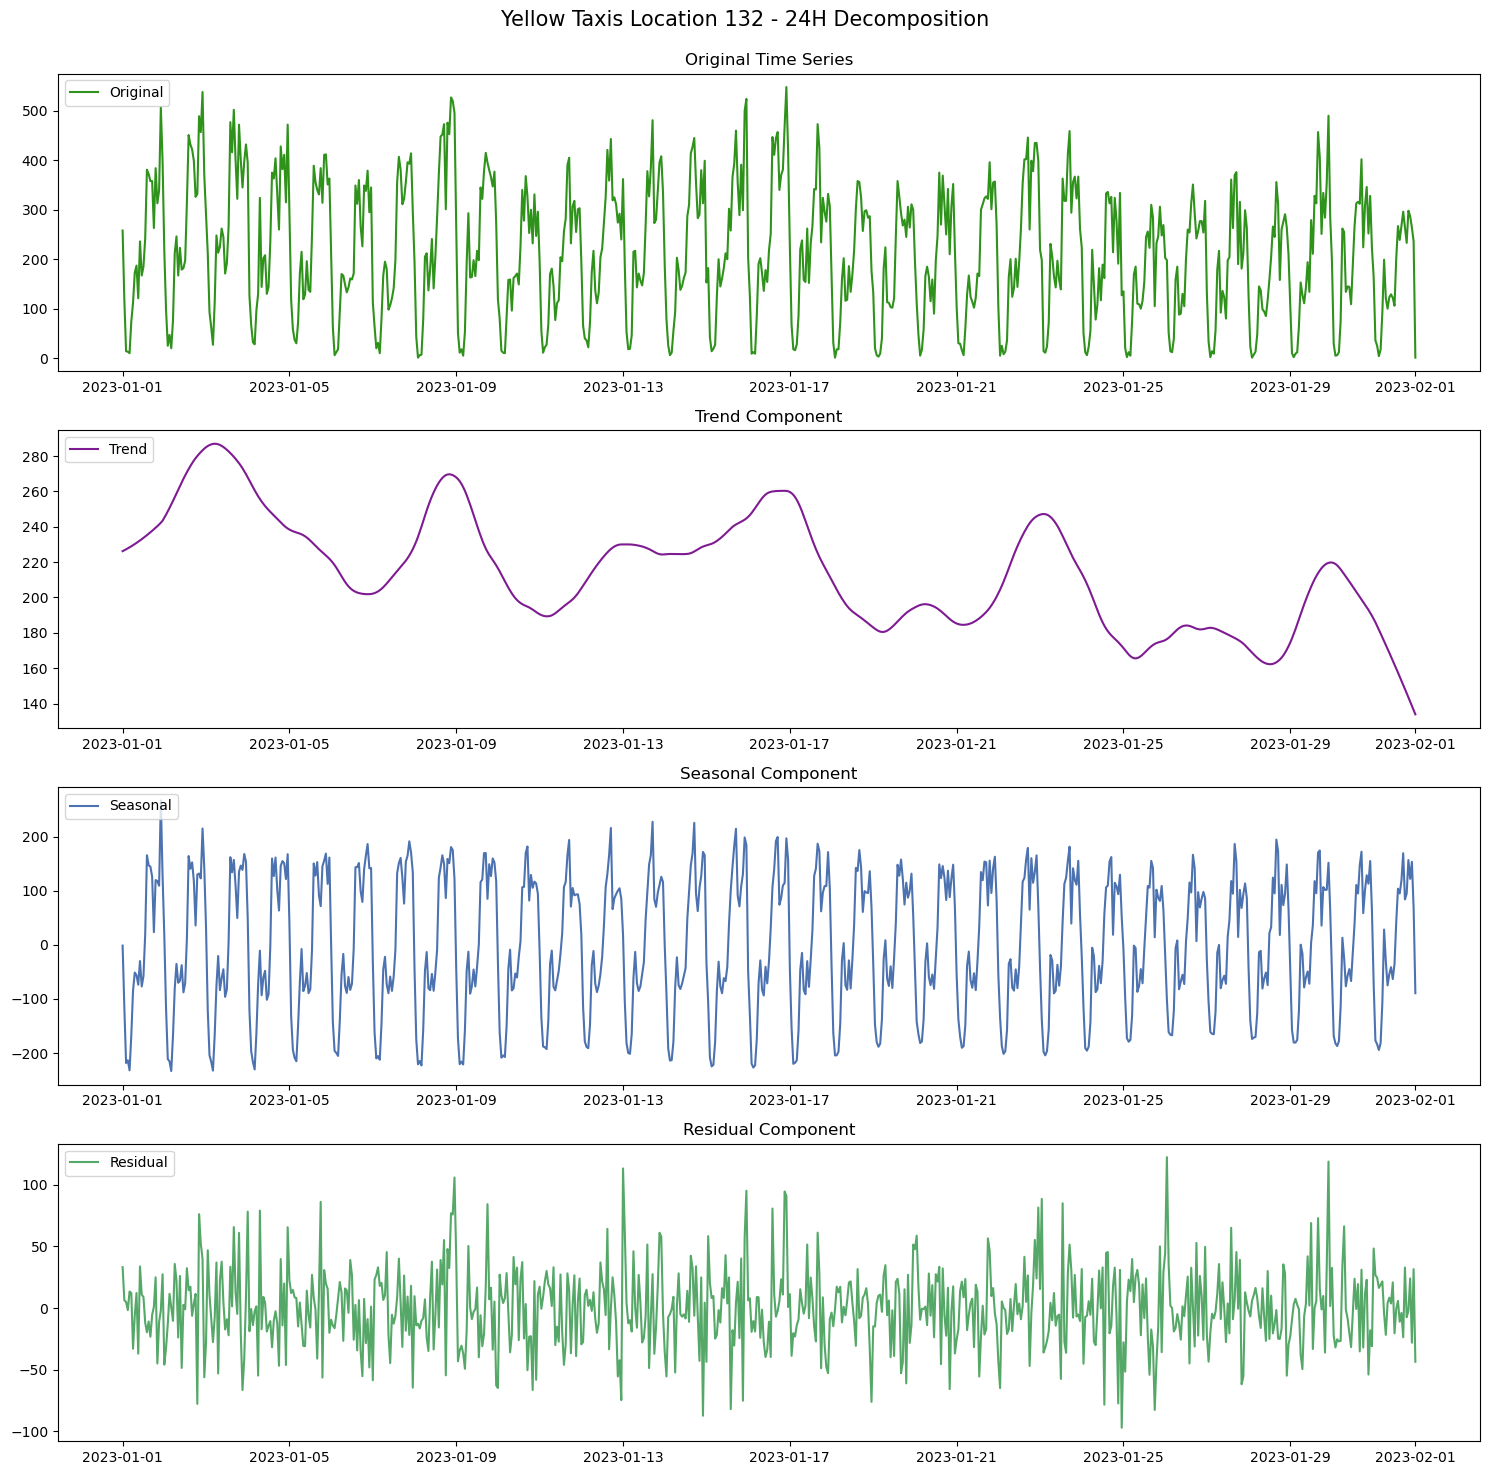

In [11]:
decomposition = STL(yellow_132, period=24).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(yellow_132, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.suptitle('Yellow Taxis Location 132 - 24H Decomposition\n', fontsize=15)
plt.tight_layout()
plt.show()

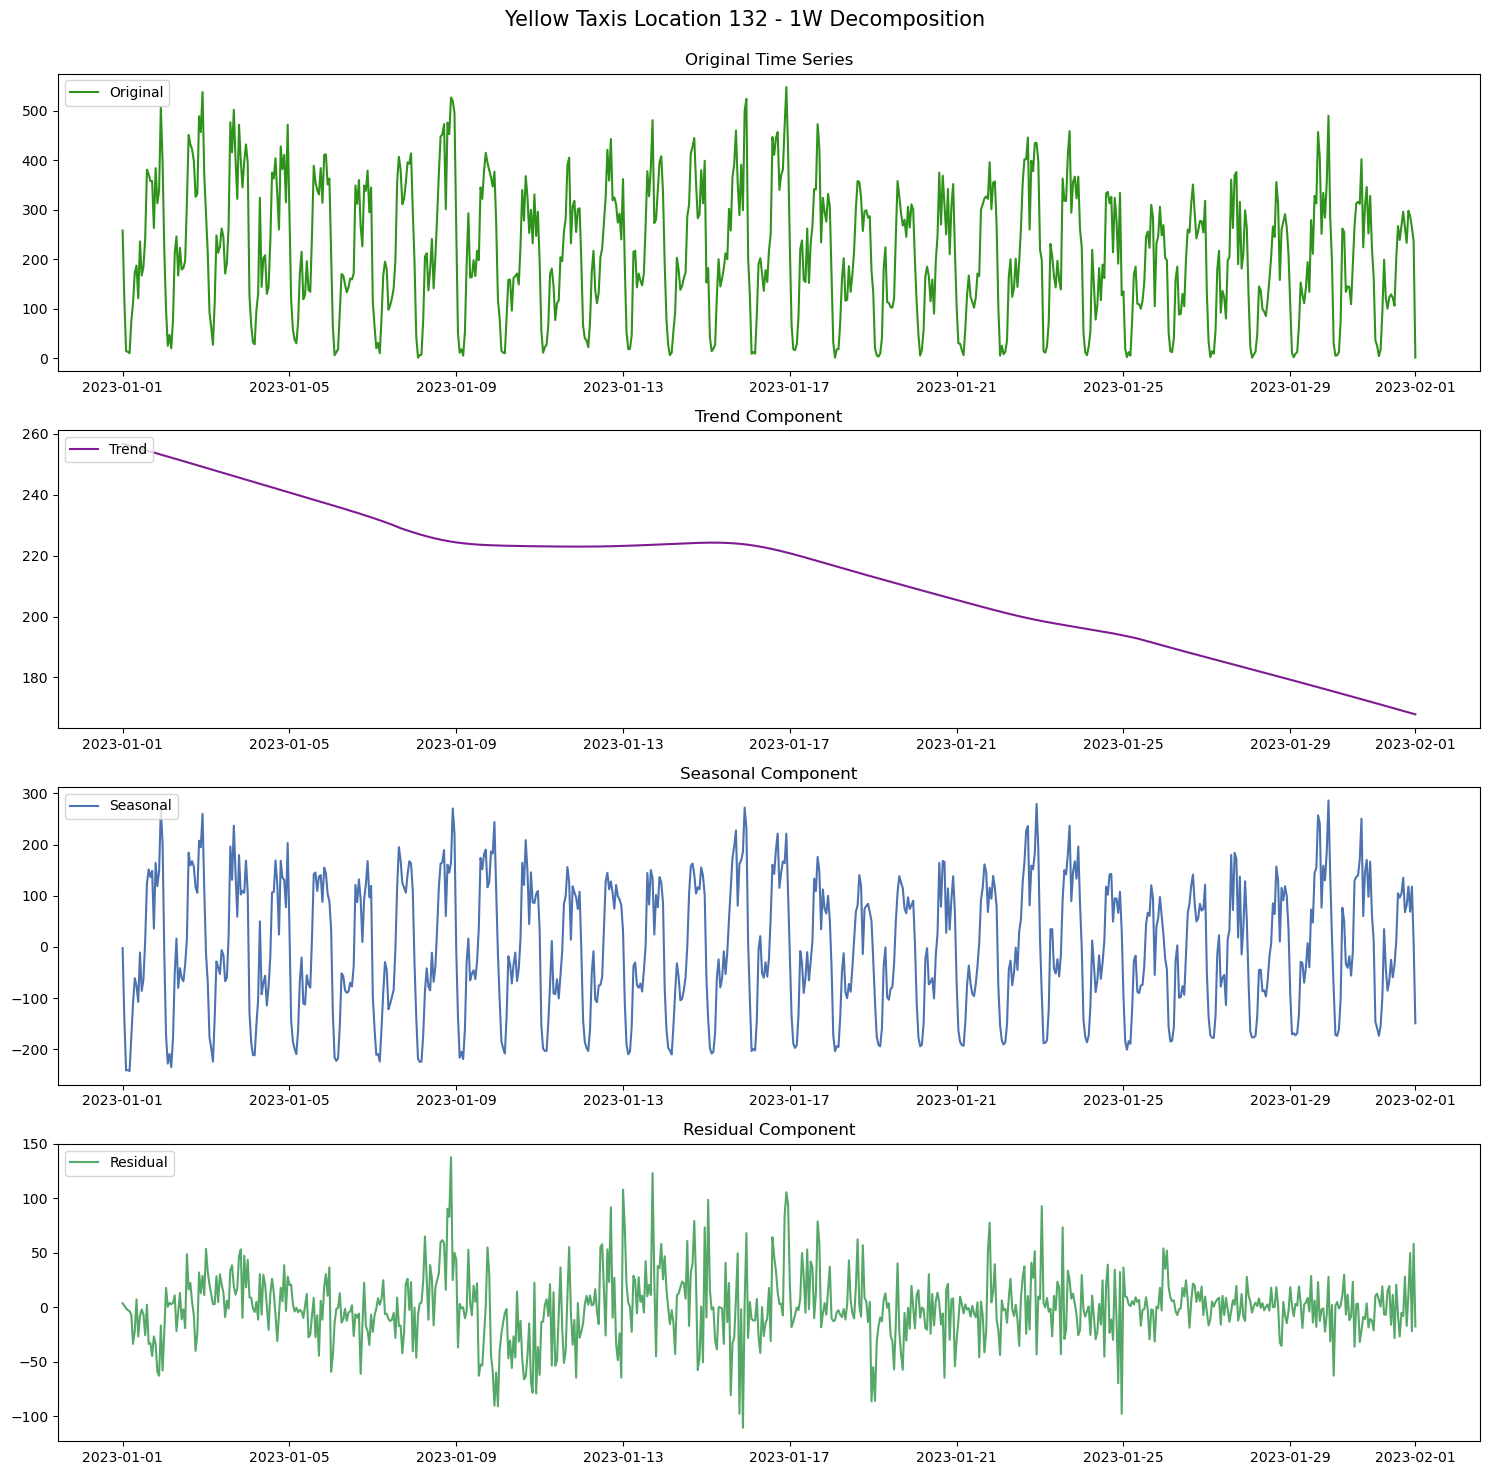

In [12]:
decomposition = STL(yellow_132, period=24*7).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(yellow_132, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.suptitle('Yellow Taxis Location 132 - 1W Decomposition\n', fontsize=15)
plt.tight_layout()
plt.show()

### ARIMA Modelling

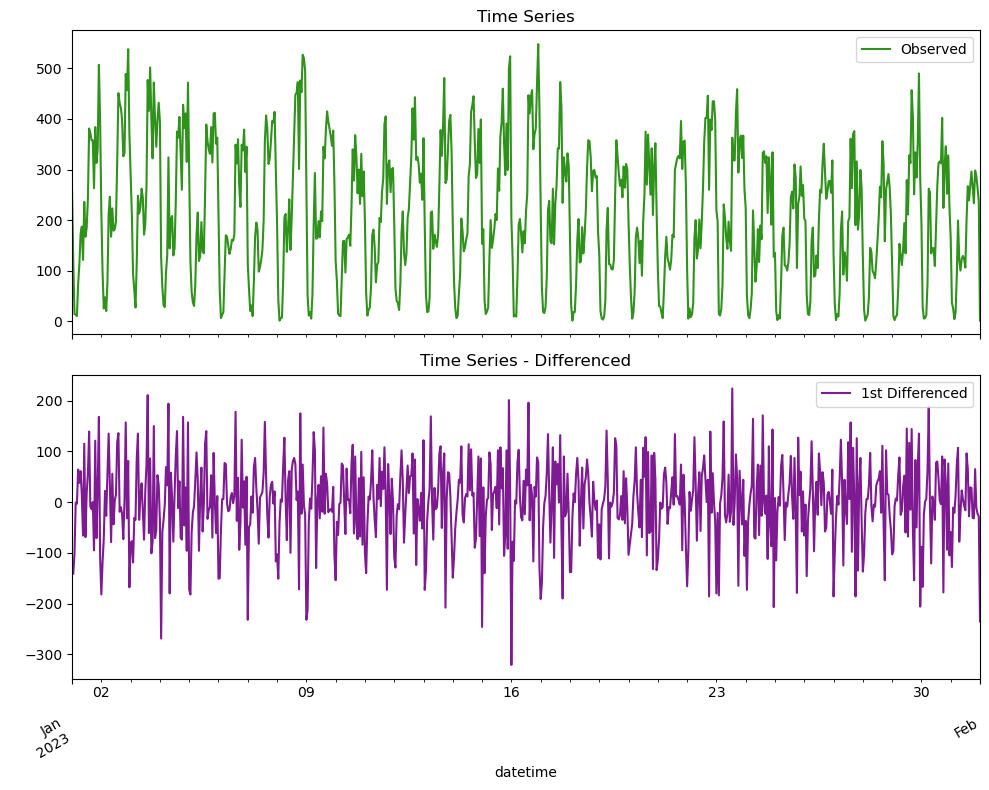

In [13]:
target_diff = yellow_132.diff()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
yellow_132.plot(title='Time Series', ax=ax1, color=deep_colors[0], label='Observed')
target_diff.plot(title='Time Series - Differenced', ax=ax2, color=deep_colors[1], label='1st Differenced')

ax1.legend()
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [14]:
ad_fuller_result = adfuller(yellow_132[1:])
print('Observed')
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

print('\n')
ad_fuller_result = adfuller(target_diff[1:])
print('1st Differenced')
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

Observed
ADF Statistic: -3.7102528310915917
p-value: 0.003971228506976234


1st Differenced
ADF Statistic: -20.198492646171847
p-value: 0.0


Significant lags exist for both autocorrelation and partial autocorrelation plots.

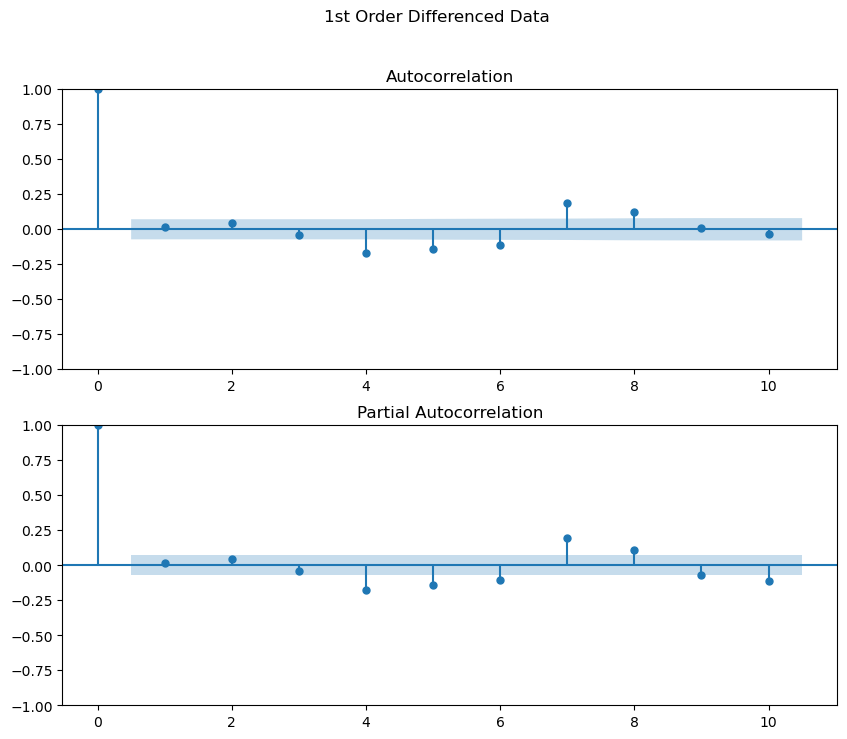

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(target_diff[1:], lags=10, ax=ax1)
plot_pacf(target_diff[1:], lags=10, ax=ax2)
plt.suptitle('1st Order Differenced Data')
plt.show()

**Train Test Split**

In [16]:
yl_train, yl_test = target_diff.loc[target_diff.index <= '2023-01-24'], target_diff.loc[target_diff.index > '2023-01-24']

yl_train.shape, yl_test.shape

((553,), (192,))

ARIMA Modelling:

In [17]:
def optimize_ARIMA(
        endog: Union[pd.Series, list], order_list: list, d: int,
) -> pd.DataFrame:

    results = []

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for order in notebook.tqdm(order_list):
            try:
                model = SARIMAX(
                    endog,
                    order=(order[0], d, order[1]),
                    simple_differencing=False).fit(disp=False)
            except:
                continue

            aic = model.aic
            results.append([order, aic])

        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q)', 'AIC']

        result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

        return result_df

In [70]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [71]:
d = 1
result_df = optimize_ARIMA(yl_train, order_list, d)
result_df.head()

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(2, 3)",6425.829431
1,"(0, 1)",6435.638710
2,"(1, 1)",6435.697667
3,"(3, 3)",6435.709618
4,"(0, 2)",6435.873487


In [83]:
result_df.shape

(16, 2)

In [85]:
i = 0
ARIMA_model = SARIMAX(
    endog=yl_train,
    order=(result_df.iloc[i,0][0], d, result_df.iloc[i,0][1]),
    simple_differencing=False
)
ARIMA_model = ARIMA_model.fit(disp=False)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:            total_trips   No. Observations:                  553
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -3206.915
Date:                Sat, 06 Jan 2024   AIC                           6425.829
Time:                        19:18:04   BIC                           6451.711
Sample:                    01-01-2023   HQIC                          6435.942
                         - 01-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2763      0.027    -46.677      0.000      -1.330      -1.223
ar.L2         -0.9305      0.025    -37.071      0.000      -0.980      -0.881
ma.L1          0.2980      0.135      2.200      0.0

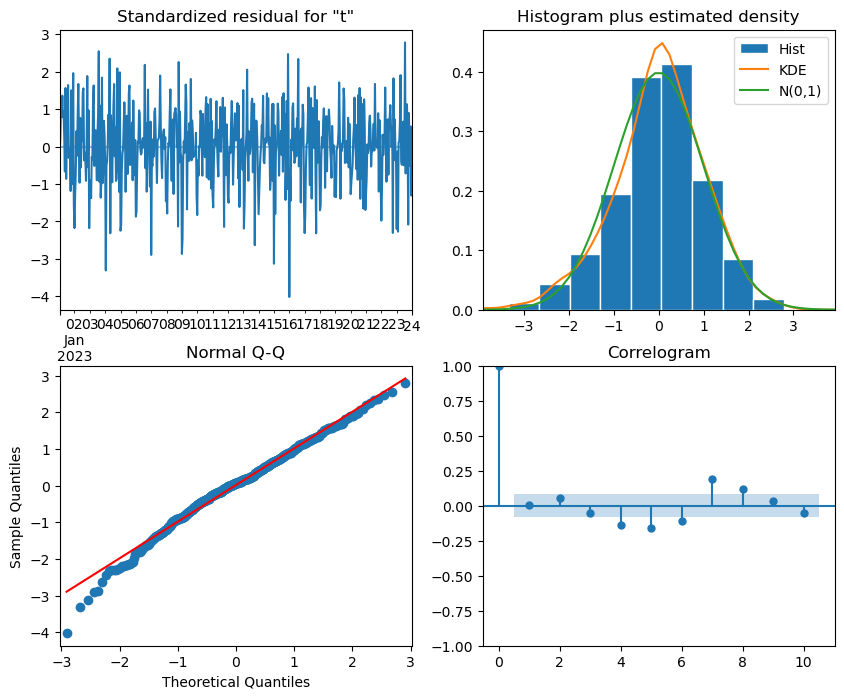

In [78]:
ARIMA_model.plot_diagnostics(figsize=(10,8))
plt.show()

In [86]:
residuals = ARIMA_model.resid
lb_df = acorr_ljungbox(residuals[1:], np.arange(1, 11, 1))

lb_df

,lb_stat,lb_pvalue
1,2.197047,1.382754e-01
2,2.338898,3.105381e-01
3,2.492078,4.767245e-01
4,17.921544,1.278437e-03
5,35.840891,1.022016e-06
6,39.215428,6.494251e-07
7,53.975077,2.378740e-09
8,64.770165,5.358388e-11
9,66.386410,7.747998e-11
10,71.001393,2.839628e-11


The ARIMA model for yellow taxis is poor. All the p-values are statistically significant, implying that the null hypothesis of no correlation between values is not validated. This is confirmed by the correlogram of the residual values. 

We may have to include exog variables and build a more complex model. It may also mean we need to do some seasonal differencing, which is a more complex model as well

In [87]:
def optimize_SARIMA(
        # The order_list parameter now includes `p`, `q`, `P`, and `Q` orders. We also add the seasonal order of differencing `D` and the frequency. Remember that the frequency `m` in the SARIMA model is denoted as `s` in the implementation in the statsmodels library.
        endog: Union[pd.Series, list], order_list: list,
        d: int, D: int, s: int
) -> pd.DataFrame:

    results = []

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for order in notebook.tqdm(order_list):
            try:
                model = SARIMAX(
                    endog,
                    order=(order[0], d, order[1]),
                    seasonal_order=(order[2], D, order[3], s),
                    simple_differencing=False).fit(disp=False)
            except:
                continue
    
            aic = model.aic
            results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [88]:
ps = range(0, 3, 1)
qs = range(0, 3, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)
d = 1
D = 0
s = 24

order_list = list(product(ps, qs, Ps, Qs))

result_df = optimize_SARIMA(yl_train, order_list, d, D, s)
result_df.head()

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
result_df.head()

,"(p,q,P,Q)",AIC
0,"(1, 1, 2, 2)",14.000000
1,"(2, 0, 2, 2)",731.465866
2,"(1, 1, 1, 2)",4787.050426
3,"(0, 2, 2, 2)",5952.363897
4,"(1, 2, 2, 1)",5979.066490
5,"(1, 2, 2, 0)",6027.966351
6,"(0, 2, 2, 0)",6029.799248
7,"(0, 2, 1, 2)",6032.445931
8,"(1, 2, 1, 1)",6052.684474
9,"(1, 2, 2, 2)",6062.354590


This is the best ARIMA model yet, but it's still flawed. We'll use it to predict:

In [66]:
i = 5
SARIMA_model = SARIMAX(
    endog=yl_train,
    order=(result_df.iloc[i,0][0], d, result_df.iloc[i,0][1]),
    seasonal_order=(result_df.iloc[i,0][2], D, result_df.iloc[i,0][3], s),
    simple_differencing=False
)
SARIMA_model = SARIMA_model.fit(disp=False)
print(SARIMA_model.summary())

/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                         total_trips   No. Observations:                  553
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 24)   Log Likelihood               -3007.983
Date:                             Sat, 06 Jan 2024   AIC                           6027.966
Time:                                     19:10:34   BIC                           6053.848
Sample:                                 01-01-2023   HQIC                          6038.079
                                      - 01-24-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1665      0.043      3.853      0.000       0.082       0.251
ma.L1         -1.8631      

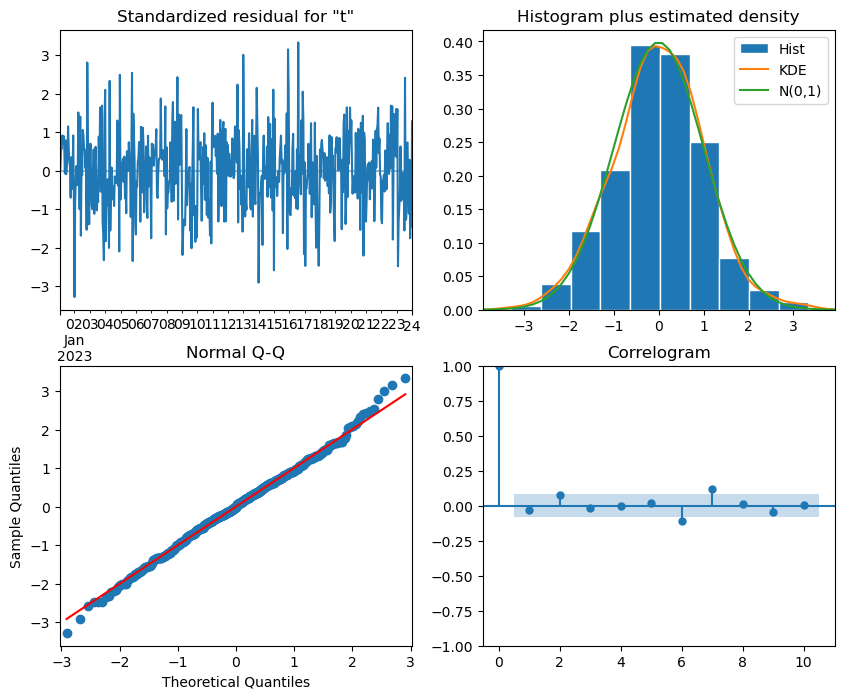

In [67]:
SARIMA_model.plot_diagnostics(figsize=(10,8))
plt.show()

In [69]:
residuals = SARIMA_model.resid
lb_df = acorr_ljungbox(residuals[1:], np.arange(1, 11, 1))

lb_df

,lb_stat,lb_pvalue
1,0.600157,0.438518
2,4.320382,0.115303
3,4.570120,0.206120
4,4.769311,0.311797
5,5.119971,0.401415
6,8.961028,0.175782
7,15.949884,0.025578
8,16.957096,0.030559
9,17.867553,0.036742
10,17.927056,0.056207


### Building a Baseline Model

We'll build 2 baseline models:
* average value
* last hour value

In [3]:
list(range(100, 120, 5))

[100, 105, 110, 115]

In [ ]:
def rolling_forecast(
        df: pd.Series, horizon: int, window_size: int, method: str, order: tuple, seasonal_order: tuple
) -> list:

    train_len = len(df)
    total_len = train_len + horizon
    
    if method == 'mean':
        forecasts = []
        history = list(df)
        for i in range(train_len, total_len, window_size):
            if i >= window_size:
                train_data = history[i - window_size:i]
                forecast = sum(train_data) / window_size
                forecasts.append(forecast)
            else:
                forecasts.append(None)
        return forecasts[:horizon]

    elif method == 'last':
        forecasts = []
        history = list(df)
        for i in range(train_len, total_len, window_size):
            if i >= window_size:
                forecast = history[i - 1]
                forecasts.append(forecast)
            else:
                forecasts.append(None)
        return forecasts

    elif method == 'SARIMA':
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            forecasts = []
            history = list(df)
            for i in range(train_len, total_len, window_size):
                if i >= window_size:
                    train_data = history[i - window_size:i]
                    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
                    model_fit = model.fit()
                    forecast = model_fit.forecast(steps=1)[0]
                    forecasts.append(forecast)
                else:
                    forecasts.append(None)
        return forecasts

In [ ]:
def recursive_forecast(
        df: pd.Series, order: tuple, seasonal_order: tuple, method: str, horizon: int
) -> list:
    if method == 'mean':
        forecasts = []
        history = list(df)
        for i in range(len(df)):
            forecast = sum(history) / len(history)
            forecasts.append(forecast)
            history.append(forecast)
        return forecasts
    
    elif method == 'last':
        forecasts = []
        history = list(df)
        for i in range(len(df)):
            forecast = history[-1]
            forecasts.append(forecast)
            history.append(forecast)
        return forecasts
    
    elif method == 'SARIMA':
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            forecasts = []
            history = list(df)
            for i in range(len(df)):
                model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=1)[0]
                forecasts.append(forecast)
                history.append(forecast)
        return forecasts

In [ ]:


# Recursive forecast using SARIMA
def recursive_sarima_forecast(series, order, seasonal_order):
    forecasts = []
    history = list(series)
    for i in range(len(series)):
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)[0]
        forecasts.append(forecast)
        history.append(forecast)
    return forecasts

# Rolling forecast using SARIMA
def rolling_sarima_forecast(series, order, seasonal_order, window_size):
    forecasts = []
    history = list(series)
    for i in range(len(series)):
        if i >= window_size:
            train_data = history[i - window_size:i]
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=1)[0]
            forecasts.append(forecast)
        else:
            forecasts.append(None)
    return forecasts

# Recursive mean forecast
def recursive_mean_forecast(series):
    forecasts = []
    history = list(series)
    for i in range(len(series)):
        forecast = sum(history) / len(history)
        forecasts.append(forecast)
        history.append(forecast)
    return forecasts

# Rolling mean forecast
def rolling_mean_forecast(series, window_size):
    forecasts = []
    history = list(series)
    for i in range(len(series)):
        if i >= window_size:
            train_data = history[i - window_size:i]
            forecast = sum(train_data) / window_size
            forecasts.append(forecast)
        else:
            forecasts.append(None)
    return forecasts

# Recursive last value forecast
def recursive_last_value_forecast(series):
    forecasts = []
    history = list(series)
    for i in range(len(series)):
        forecast = history[-1]
        forecasts.append(forecast)
        history.append(forecast)
    return forecasts

# Rolling last value forecast
def rolling_last_value_forecast(series, window_size):
    forecasts = []
    history = list(series)
    for i in range(len(series)):
        if i >= window_size:
            forecast = history[i - 1]
            forecasts.append(forecast)
        else:
            forecasts.append(None)
    return forecasts

# Define SARIMA order and seasonal_order
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Example seasonal order with a period of 12 (for monthly data)

window_size = 5  # Define the rolling window size

# Generate SARIMA forecasts
recursive_sarima = recursive_sarima_forecast(time_series, order, seasonal_order)
rolling_sarima = rolling_sarima_forecast(time_series, order, seasonal_order, window_size)

# Generate mean forecasts
recursive_mean = recursive_mean_forecast(time_series)
rolling_mean = rolling_mean_forecast(time_series, window_size)

# Generate last value forecasts
recursive_last_value = recursive_last_value_forecast(time_series)
rolling_last_value = rolling_last_value_forecast(time_series, window_size)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Original Data', marker='o')
plt.plot(recursive_sarima, label='Recursive SARIMA Forecast', linestyle='--', marker='o')
plt.plot(range(window_size, len(time_series)), rolling_sarima[window_size:], label='Rolling SARIMA


In [ ]:
TRAIN_LEN = len(yl_train)
HORIZON = len(yl_test)
WINDOW = 2
d = 1

pred_mean = rolling_forecast(target_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(target_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(target_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA', pdq=(result_df.iloc[0,0][0], 0, result_df.iloc[0,0][1]))

pred_df = pd.DataFrame({'actual': yl_test})
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARIMA'] = pred_ARIMA
pred_df['pred_mean'] = pred_mean

pred_df.head()

In [ ]:
fig, ax = plt.subplots()

ax.plot(target_diff)
ax.plot(pred_df['actual'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_ARIMA'], 'k--', label='ARIMA(3,1,2)')

ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Trips')
ax.set_title('Total Trips for Yellow 132')

start_date = pd.to_datetime('2023-01-21')
end_date = pd.to_datetime('2023-02-01')
plt.xlim(start_date, end_date)  # Set the x-axis limits

highlight_start = pd.to_datetime('2023-01-24')
highlight_end = pd.to_datetime('2023-02-01')
plt.axvspan(highlight_start, highlight_end, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Evaluate:

In [ ]:
rmse_mean = mean_squared_error(pred_df['actual'], pred_df['pred_mean'], squared=False)
rmse_last = mean_squared_error(pred_df['actual'], pred_df['pred_last_value'], squared=False)
rmse_ARIMA_312 = mean_squared_error(pred_df['actual'], pred_df['pred_ARIMA'], squared=False)

In [ ]:
plt.figure(figsize=(12, 10))
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARIMA(3,1,2)']
y = [rmse_mean, rmse_last, rmse_ARIMA_312]

ax.bar(x, y, width=0.4)
ax.set_ylabel('RMSE')
ax.set_title('Yellow 132 Total Trips: RMSE')
ax.set_xticks([])
for index, value in enumerate(y):
    ax.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

plt.tight_layout()
plt.show()

In [ ]:
yellow_132 = pd.DataFrame(yellow_132)
yellow_132.loc[yl_test.index, 'pred_ARIMA'] = yellow_132.loc[yl_test.index[-1], 'total_trips'] + pred_df['pred_ARIMA'].cumsum()

fig, ax = plt.subplots()

ax.plot(yellow_132['total_trips'])
ax.plot(yellow_132.loc[yl_test.index, 'total_trips'], 'b-', label='actual')
ax.plot(yellow_132.loc[yl_test.index, 'pred_ARIMA'], 'k--', label='ARIMA(3,1,2)')
ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Trips')
ax.set_title('Yellow 132 Total Trips + ARIMA Forecasts Undiff')

start_date = pd.to_datetime('2023-01-21')
end_date = pd.to_datetime('2023-02-01')
plt.xlim(start_date, end_date)  # Set the x-axis limits

highlight_start = pd.to_datetime('2023-01-24')
highlight_end = pd.to_datetime('2023-02-01')
plt.axvspan(highlight_start, highlight_end, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Improve Baseline Model Using ML

4 ways to improve your initial model:

- Increase the training data (aka more rows)
- Increase the number of features (aka more columns)
- Try another ML algorithm (e.g. XGBoost instead of LightGM)
- Fine-tune model hyper-parameters

**Neural Network**

In [ ]:
time_series_data = yellow_132['total_trips'].values.astype(float)

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_data = scaler.fit_transform(time_series_data.reshape(-1, 1))

# Define a function to create sequences and labels for time series data
def create_sequences(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Create sequences and labels (let's use a look-back of 3 for instance)
look_back = 5
X, y = create_sequences(time_series_data, look_back)

# Reshape input to be [samples, time steps, features] expected by LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Splitting the data into train and test sets
train_size = X.shape[0] - yl_test.shape[0]
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(look_back, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
rmse_LSTM = mean_squared_error(y_test, predictions, squared=False)
print(f"\nRoot Mean Squared Error: {rmse_LSTM}")

yellow_132.loc[yl_test.index[0]:,'pred_LSTM'] = predictions

In [ ]:
fig, ax = plt.subplots()

ax.plot(yellow_132['total_trips'])
ax.plot(yellow_132.loc[yl_test.index, 'total_trips'], 'b-', label='actual')
ax.plot(yellow_132.loc[yl_test.index, 'pred_ARIMA'], 'k--', label='ARIMA(3,1,2)')
ax.plot(yellow_132.loc[yl_test.index, 'pred_LSTM'], 'r-.', label='LSTM')
ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Trips')
ax.set_title('Yellow 132 Total Trips + ARIMA Forecasts Undiff')

start_date = pd.to_datetime('2023-01-21')
end_date = pd.to_datetime('2023-02-01')
plt.xlim(start_date, end_date)  # Set the x-axis limits

highlight_start = pd.to_datetime('2023-01-24')
highlight_end = pd.to_datetime('2023-02-01')
plt.axvspan(highlight_start, highlight_end, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

**Tree Model**

In [ ]:
df = pd.DataFrame(yellow_132.total_trips).copy()
df['lagged_trips'] = df['total_trips'].shift(1)  # Creating a lagged feature
df['rolling_mean'] = df['total_trips'].rolling(window=3).mean()  # Rolling mean as a feature

# Drop rows with NaNs due to lagged features or rolling statistics
df.dropna(inplace=True)

# Splitting the data into train and test sets
train, test = df.loc[~df.index.isin(yl_test.index)], df.loc[yl_test.index]

# Define features and target variable
features = ['lagged_trips', 'rolling_mean']  # Define your engineered features
target = 'total_trips'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Initialize XGBoost model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
rmse_XGB = mean_squared_error(y_test, predictions, squared=False)
print(f"Root Mean Squared Error: {rmse_XGB}")

yellow_132.loc[yl_test.index[0]:,'pred_XGB'] = predictions

In [ ]:
fig, ax = plt.subplots()

ax.plot(yellow_132['total_trips'])
ax.plot(yellow_132.loc[yl_test.index, 'total_trips'], 'b-', label='actual')
ax.plot(yellow_132.loc[yl_test.index, 'pred_ARIMA'], 'k--', label='ARIMA(3,1,2)')
ax.plot(yellow_132.loc[yl_test.index, 'pred_LSTM'], 'r-.', label='LSTM')
ax.plot(yellow_132.loc[yl_test.index, 'pred_XGB'], 'g--', label='XGB')
ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Trips')
ax.set_title('Yellow 132 Total Trips + Forecasts')

start_date = pd.to_datetime('2023-01-21')
end_date = pd.to_datetime('2023-02-01')
plt.xlim(start_date, end_date)  # Set the x-axis limits

highlight_start = pd.to_datetime('2023-01-24')
highlight_end = pd.to_datetime('2023-02-01')
plt.axvspan(highlight_start, highlight_end, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Evaluate RMSE:

In [ ]:
x = ['mean', 'last_value', 'ARIMA(3,1,2)', 'LSTM', 'XGB']
y = [rmse_mean, rmse_last, rmse_ARIMA_312, rmse_LSTM, rmse_XGB]

fig, ax = plt.subplots()

ax.bar(x, y, width=0.4)
ax.set_ylabel('RMSE')
ax.set_title('Yellow 132 Total Trips: RMSE')
for index, value in enumerate(y):
    ax.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

plt.tight_layout()
plt.show()

### Green 74 - Forecasting

**Time Series Decomposition**

In [ ]:
decomposition = STL(green_74, period=24).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(green_74, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.suptitle('Green Taxis Location 74 - 24H Decomposition\n', fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
decomposition = STL(green_74, period=24*7).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(green_74, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.suptitle('Green Taxis Location 74 - 1W Decomposition\n', fontsize=15)
plt.tight_layout()
plt.show()

### Modelling

**ARIMA Modelling**

In [ ]:
target_diff = green_74.diff()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
green_74.plot(title='Time Series', ax=ax1, color=deep_colors[0], label='Observed')
target_diff.plot(title='Time Series - Differenced', ax=ax2, color=deep_colors[1], label='Differenced')
ax1.legend()
ax2.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
ad_fuller_result = adfuller(green_74[1:])
print('Observed')
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

print('\n')
ad_fuller_result = adfuller(target_diff[1:])
print('Differenced')
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(target_diff[1:], lags=10, ax=ax1)
plot_pacf(target_diff[1:], lags=10, ax=ax2)
plt.show()

In [ ]:
def optimize_ARIMA(
        endog: Union[pd.Series, list], order_list: list, d: int,
        # D: int, s: int
) -> pd.DataFrame:

    results = []

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for order in notebook.tqdm(order_list):
            try:
                model = SARIMAX(
                    endog,
                    order=(order[0], d, order[1]),
                    simple_differencing=False).fit(disp=False)
            except:
                continue

            aic = model.aic
            results.append([order, aic])

        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q)', 'AIC']

        result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

        return result_df

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

result_df = optimize_ARIMA(green_74, order_list, d)
result_df.head()

In [ ]:
ARIMA_model = SARIMAX(
    endog=green_74,
    order=(result_df.iloc[0,0][0], d, result_df.iloc[0,0][1]),
    simple_differencing=False
)
ARIMA_model = ARIMA_model.fit(disp=False)
print(ARIMA_model.summary())

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(10,8))
plt.show()

In [ ]:
residuals = ARIMA_model.resid
lb_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_df

In [ ]:
def rolling_forecast(
        df: pd.DataFrame, train_len: int, horizon: int,
        window: int, method: str, pdq=(0,0,0)
) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            # mean = np.mean(df[:i].values)
            mean = df[:i].mean()
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1]#.values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARIMA':
        pred_ARIMA = []
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            for i in range(train_len, total_len, window):
                model = SARIMAX(df[:i], order=pdq)
                res = model.fit(disp=False)
                predictions = res.get_prediction(0, i + window - 1)
                oos_pred = predictions.predicted_mean.iloc[-window:]
                pred_ARIMA.extend(oos_pred)

        return pred_ARIMA

In [ ]:
gn_train, gn_test = target_diff.loc[target_diff.index <= '2023-01-24'], target_diff.loc[target_diff.index > '2023-01-24']

gn_train.shape, gn_test.shape

In [ ]:
TRAIN_LEN = len(gn_train)
HORIZON = len(gn_test)
WINDOW = 3
d = 1

pred_mean = rolling_forecast(target_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(target_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(target_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA', pdq=(result_df.iloc[0,0][0], d, result_df.iloc[0,0][1]))

pred_df = pd.DataFrame({'actual': yl_test})
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARIMA'] = pred_ARIMA
pred_df['pred_mean'] = pred_mean

pred_df.head()

In [ ]:
fig, ax = plt.subplots()

ax.plot(target_diff)
ax.plot(pred_df['actual'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_ARIMA'], 'k--', label='ARIMA(3,1,2)')

ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Trips')
ax.set_title('Total Trips for Yellow 132')

start_date = pd.to_datetime('2023-01-21')
end_date = pd.to_datetime('2023-02-01')
plt.xlim(start_date, end_date)  # Set the x-axis limits

highlight_start = pd.to_datetime('2023-01-24')
highlight_end = pd.to_datetime('2023-02-01')
plt.axvspan(highlight_start, highlight_end, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
yellow_132 = pd.DataFrame(yellow_132)
yellow_132.loc[yl_test.index, 'pred_ARIMA'] = yellow_132.loc[yl_test.index[-1], 'total_trips'] + pred_df['pred_ARIMA'].cumsum()

fig, ax = plt.subplots()

ax.plot(yellow_132['total_trips'])
ax.plot(yellow_132.loc[yl_test.index, 'total_trips'], 'b-', label='actual')
ax.plot(yellow_132.loc[yl_test.index, 'pred_ARIMA'], 'k--', label='ARIMA(3,1,2)')
ax.legend(loc=2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Trips')
ax.set_title('Yellow 132 Total Trips + ARIMA Forecasts Undiff')

start_date = pd.to_datetime('2023-01-21')
end_date = pd.to_datetime('2023-02-01')
plt.xlim(start_date, end_date)  # Set the x-axis limits

highlight_start = pd.to_datetime('2023-01-24')
highlight_end = pd.to_datetime('2023-02-01')
plt.axvspan(highlight_start, highlight_end, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
rmse_mean = mean_squared_error(pred_df['actual'], pred_df['pred_mean'], squared=False)
rmse_last = mean_squared_error(pred_df['actual'], pred_df['pred_last_value'], squared=False)
rmse_ARIMA_312 = mean_squared_error(pred_df['actual'], pred_df['pred_ARIMA'], squared=False)

plt.figure(figsize=(12, 10))
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARIMA(3,1,2)']
y = [rmse_mean, rmse_last, rmse_ARIMA_312]

ax.bar(x, y, width=0.4)
ax.set_ylabel('RMSE')
ax.set_title('Yellow 132 Total Trips: RMSE')
ax.set_xticks([])
for index, value in enumerate(y):
    ax.text(x=index, y=value + 0.1, s=str(round(value,2)), ha='center')

plt.tight_layout()
plt.show()

### Model Deployment

We'll use the 3-pipeline architecture, to build a batch-scoring system with
- A feature pipeline
- A training pipeline
- An inference pipeline

### Monitoring Dashboard

We'll use Streamlit to build an app that fetches
- model predictions, and
- actual targets

and plots the online error metric.

This number should be close to the offline metrics you got when you trained your model.